In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from numpy import linalg as LA
import numpy as np
import random

f = open('./faithful.dat','r')
f.readline()

data = []
for line in f:
    eruption, waiting = line.split()[1::]
    data.append([float(eruption), float(waiting)])

data = np.array(data)
data[:,0] = (data[:,0] - min(data[:,0])) / (max(data[:,0]) - min(data[:,0]))
data[:,1] = (data[:,1] - min(data[:,1])) / (max(data[:,1]) - min(data[:,1]))

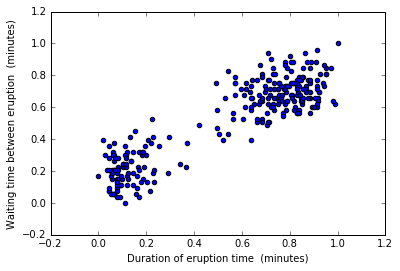

In [2]:
plt.scatter([row[0] for row in data], [row[1] for row in data], norm=1)
plt.xlabel('Duration of eruption time  (minutes)')
plt.ylabel('Waiting time between eruption  (minutes)')
plt.show()

In [97]:
def EM(xs, pi, mus, sigmas, tol):
    n = len(xs)
    res = np.zeros((1, n))[0]
    diff = 1.0
    iterate = 0
    
    #trajectory of two mean vectors in 2 dimension
    #trajectory: coordinates vs. iteration
    trajectories = []
    
    while diff >= tol:
        iterate += 1
        prev_res = np.array(res)

        # E-Step
        # Compute Respinsibility, using Bayes Rule to compute the posterior
        # i.e. The importance of each xi for each assumed Gaussian distribution
        for i, x in enumerate(xs):
            res[i] = pi * mvn.pdf(x, mus[1], sigmas[1] * sigmas[1] * np.identity(2)) / ((1-pi) * mvn.pdf(x, mus[0], sigmas[0] * sigmas[0] * np.identity(2)) + pi * mvn.pdf(x, mus[1], sigmas[1] * sigmas[1] * np.identity(2)))
#         print (res)
        
        # M-Step
        # Update the mean and covariance using the responsibility
        mus = [[0.0, 0.0], [0.0, 0.0]]
        for i, x in enumerate(xs):
            mus[0] += (1 - res[i]) * x
            mus[1] += res[i] * x
        mus[0] /= sum(1 - res)
        mus[1] /= sum(res)
#         print ('mus[0]:', mus[0], ", mus[1]:", mus[1])
        
        pi = sum(res) / n
        
        
        sigmas = [0.0, 0.0]
        for i, x in enumerate(xs):
            # We use average of the diagonal to obtain the 
            sigmas[0] += (1 - res[i]) * (np.outer((x - mus[0]), (x - mus[0]).T).trace()) / 2
            sigmas[1] += res[i] * (np.outer((x - mus[1]), (x - mus[1]).T).trace()) / 2
        sigmas[0] /= sum(1 - res)
        sigmas[0] = math.sqrt(sigmas[0])
        sigmas[1] /= sum(res)
        sigmas[1] = math.sqrt(sigmas[1])
#         print ('sigmas[0]:', sigmas[0], ", sigmas[1]:", sigmas[1])

        diff = sum(abs(prev_res - res))
#         print ('iteration', iterate, ': ', diff)

        trajectories.append([mus[0], mus[1]])
        
    return trajectories, mus[0], sigmas[0], mus[1], sigmas[1], iterate

trajectories, mu1, sigma1, mu2, sigma2, iteration = EM(data, 0.5, [[0.0, 0.0], [1.0, 1.0]], [0.5, 0.5], 0.00001)
print ('trajectories', trajectories)
print ('mus[0]', mu1)
print ('sigmas[0]', sigma1)
print ('mus[1]', mu2)
print ('sigmas[1]', sigma2)

trajectories [[array([ 0.25889739,  0.3123132 ]), array([ 0.75081925,  0.68773446])], [array([ 0.158307  ,  0.24003511]), array([ 0.77733165,  0.70516424])], [array([ 0.13907968,  0.22563032]), array([ 0.77510781,  0.70346828])], [array([ 0.12903097,  0.21965996]), array([ 0.77093979,  0.69944576])], [array([ 0.12577436,  0.21736144]), array([ 0.76927879,  0.69812888])], [array([ 0.12539311,  0.21705658]), array([ 0.76905649,  0.69797392])], [array([ 0.12536302,  0.21703192]), array([ 0.76903795,  0.69796127])], [array([ 0.12536073,  0.21703004]), array([ 0.76903652,  0.6979603 ])], [array([ 0.12536056,  0.2170299 ]), array([ 0.76903641,  0.69796023])], [array([ 0.12536055,  0.21702989]), array([ 0.7690364 ,  0.69796022])]]
mus[0] [ 0.12536055  0.21702989]
sigmas[0] 0.09449678475559663
mus[1] [ 0.7690364   0.69796022]
sigmas[1] 0.11485972032434151


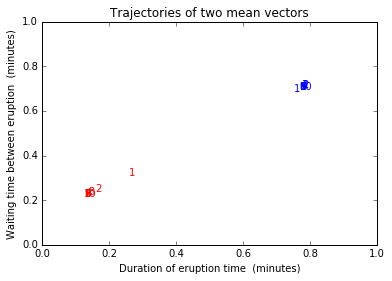

In [98]:
# Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # create an axes object in the 1*1 figure
plt.title('Trajectories of two mean vectors')
plt.xlabel('Duration of eruption time  (minutes)')
plt.ylabel('Waiting time between eruption  (minutes)')

for i, mean in enumerate(trajectories):
    # Add text in string s to axis at location x, y, data coordinates.
    ax.text(mean[0][0], mean[0][1], i + 1, color = "red")
    ax.text(mean[1][0], mean[1][1], i + 1, color = "blue") 
plt.show()

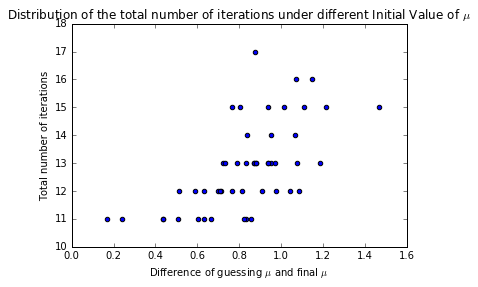

In [14]:
# Run the program for 50 times with different initial parameter guesses
# for different mean values
trajectories_list = []
distance_list = []
iteration_list = []

for i in range(50):
    random.seed()
    random_mu = [[random.random(), random.random()], [random.random(), random.random()]]
#     print (random_mu)
    trajectories, mu1, sigma1, mu2, sigma2, iteration = EM(data, 0.5, random_mu, [0.5, 0.5], 0.00001)
#     print (iteration)
    distance = LA.norm(mu1 - random_mu[0]) + LA.norm(mu2 - random_mu[1])
    trajectories_list.append(trajectories)
    iteration_list.append(iteration)
    distance_list.append(distance)

# Plot the distribution of the total number of iterations needed for algorithm to converge
plt.figure()
plt.scatter(distance_list, iteration_list)
plt.title('Distribution of the total number of iterations under different Initial Value of ' + r'$\mu$')
plt.xlabel('Difference of guessing ' + r'$\mu$' + ' and final ' + r'$\mu$')
plt.ylabel('Total number of iterations')
plt.show()

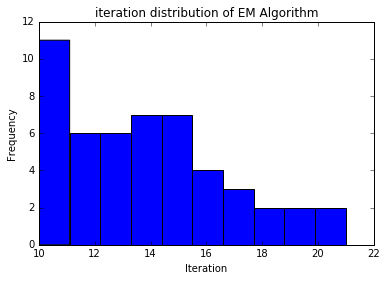

In [135]:
plt.hist(iteration_list)
plt.title("iteration distribution of EM Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Frequency")
plt.show()

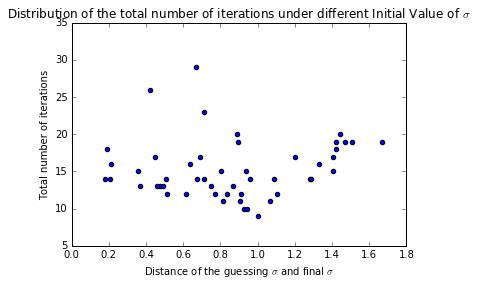

In [139]:
# for different variance values
trajectories_list = []
distance_list = []
iteration_list = []

for i in range(50):
    random.seed()
    random_sigma = [random.random(), random.random()]
    while random_sigma[0] < 0.03 or random_sigma[1] < 0.03:
        random_sigma = [random.random(), random.random()]
#     print (random_sigma)
    trajectories, mu1, sigma1, mu2, sigma2, iteration = EM(data, 0.5, [[0.5, 0.5], [0.5, 0.5]], random_sigma, 0.00001)
    distance = abs(sigma1 - random_sigma[0]) + abs(sigma2 - random_sigma[1])
    trajectories_list.append(trajectories)
    iteration_list.append(iteration)
    distance_list.append(distance)

# Plot the distribution of the total number of iterations needed for algorithm to converge
plt.figure()
plt.scatter(distance_list, iteration_list)
plt.title('Distribution of the total number of iterations under different Initial Value of ' + r'$\sigma$')
plt.xlabel('Distance of the guessing ' + r'$\sigma$' + ' and final ' + r'$\sigma$')
plt.ylabel('Total number of iterations')
plt.show()

In [140]:
def k_means(xs, k = 2, c = None):
    n = len(xs)    
    labels, random_mu = randomize_centroids(xs)
    labels = np.array(labels)
    prev_labels = []
    iterations = 0
    while not np.array_equal(prev_labels, labels):
        iterations += 1
        prev_labels = np.copy(labels)
        mu = [np.mean(xs[labels == 1], axis=0), np.mean(xs[labels == 2], axis=0)]
        labels = []
        for x in xs:
            labels.append(1 if (LA.norm(x - mu[0]) < LA.norm(x - mu[1])) else 2)
        labels = [int(x) for x in labels]
        labels = np.array(labels)
    return labels, mu, iterations, random_mu

def randomize_centroids(data):
    centroids = []
    np.random.seed()
    n = len(data[0])
    random_mu = np.random.rand(2, 2)
    for row in data:
        centroids.append(1 if (LA.norm(row - random_mu[0]) < LA.norm(row - random_mu[1])) else 2)
    centroids = [int(x) for x in centroids]
    return centroids, random_mu

labels, mu, iterations, initial_mu = k_means(data)
print ('labels: ', labels)
print ('mu: ', mu)
print ('iterations: ', iterations)
print ('with initial means: ', initial_mu)

labels:  [1 2 1 2 1 2 1 1 2 1 2 1 1 2 1 2 2 1 2 1 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 2 2
 1 2 1 1 2 1 2 1 1 1 2 1 2 1 1 2 1 2 1 1 2 1 1 2 1 2 1 2 1 1 1 2 1 1 2 1 1
 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1 1 2 1 2 1 1 1
 2 1 1 2 1 2 1 2 1 2 1 1 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 2 1 1 1 2 1 2
 1 2 1 1 2 1 1 1 1 1 2 1 2 1 2 1 1 1 2 1 2 1 2 2 1 1 1 1 1 2 1 1 2 1 1 1 2
 1 1 2 1 2 1 2 1 1 1 1 1 1 2 1 2 1 1 2 1 2 1 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1
 2 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 1 2 1 2 1 2 1 1 1 1 1 1 1 2
 1 1 1 2 1 2 2 1 1 2 1 2 1]
mu:  [array([ 0.77095402,  0.69908913]), array([ 0.12818076,  0.21967655])]
iterations:  4
with initial means:  [[ 0.89078259  0.71347133]
 [ 0.564475    0.68719095]]


iteration for kmeans:  6


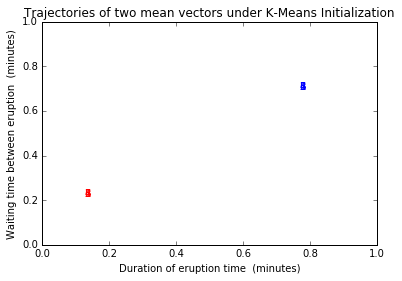

In [119]:
# generate sigma using the mus generated through kMeans
sigma = [math.sqrt(np.mean(pow((data[labels == 1] - mu[0]), 2))), math.sqrt(np.mean(pow((data[labels == 2] - mu[1]), 2)))]

trajectories, mu1, sigma1, mu2, sigma2, iteration = EM(data, 0.5, mu, sigma, 0.00001)
print ('iteration for kmeans: ', iteration)
# Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # create an axes object in the 1*1 figure
plt.title('Trajectories of two mean vectors under K-Means Initialization')
plt.xlabel('Duration of eruption time  (minutes)')
plt.ylabel('Waiting time between eruption  (minutes)')
for i, mean in enumerate(trajectories):
    # Add text in string s to axis at location x, y, data coordinates.
    ax.text(mean[0][0], mean[0][1], i + 1, color = "red")
    ax.text(mean[1][0], mean[1][1], i + 1, color = "blue") 
plt.show()

//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


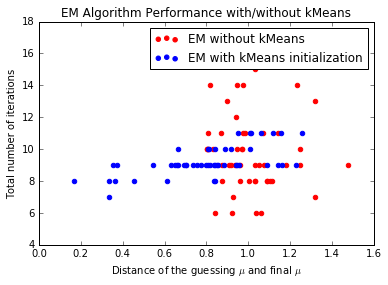

In [141]:
# compare performance of kMeans and EM
EM_dist_list = []
KM_dist_list = []
EM_iterations_list = []
KM_iterations_list = []
for i in range(50):
    old_settings = np.seterr(all='ignore')
    labels, mu_est, iterations, initial_mu = k_means(data)
#     print (initial_mu)
    # generate sigma using the mus generated through kMeans
    sigma = [math.sqrt(np.mean(pow((data[labels == 1] - mu_est[0]), 2))), math.sqrt(np.mean(pow((data[labels == 2] - mu_est[1]), 2)))]
#     print (sigma)
    while math.isnan(sigma[0]) or math.isnan(sigma[1]):
        labels, mu_est, iterations, initial_mu = k_means(data)
        sigma = [math.sqrt(np.mean(pow((data[labels == 1] - mu_est[0]), 2))), math.sqrt(np.mean(pow((data[labels == 2] - mu_est[1]), 2)))]
    # run EM with kMeans initialization
#     print (mu_est)
    trajectories, mu1_KM, sigma1, mu2_KM, sigma2, iteration_KM = EM(data, 0.5, mu_est, sigma, 0.00001)
    # run EM without kMeans initialization
    
    trajectories, mu1_EM, sigma1, mu2_EM, sigma2, iteration_EM = EM(data, 0.5, initial_mu, sigma, 0.00001)
    
    KM_dist = LA.norm(mu1_KM - initial_mu[0]) + LA.norm(mu2_KM - initial_mu[1])
    EM_dist = LA.norm(mu1_EM - initial_mu[0]) + LA.norm(mu2_EM - initial_mu[0])
    KM_dist_list.append(KM_dist)
    EM_dist_list.append(EM_dist)
    KM_iterations_list.append(iteration_KM + iterations)
    EM_iterations_list.append(iteration_EM)

plt.figure()
plt_EM = plt.scatter(EM_dist_list, EM_iterations_list, color='red', label = 'EM without kMeans')
plt_KM = plt.scatter(KM_dist_list, KM_iterations_list, color='blue', label = 'EM with kMeans initialization')
plt.title('EM Algorithm Performance with/without kMeans')
plt.xlabel('Distance of the guessing ' + r'$\mu$' + ' and final ' + r'$\mu$')
plt.ylabel('Total number of iterations')
plt.legend([plt_EM, plt_KM], ['EM without kMeans', 'EM with kMeans initialization'])
plt.show()

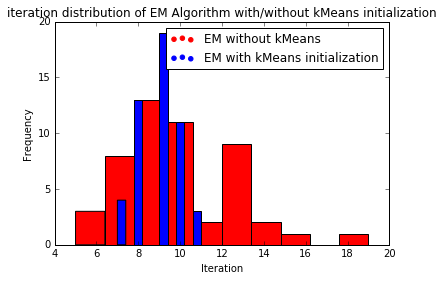

In [134]:
plt.hist(EM_iterations_list, color = "red", label = "EM without kMeans")
plt.hist(KM_iterations_list, color = "blue", label = "EM with kMeans initialization")
plt.title("iteration distribution of EM Algorithm with/without kMeans initialization")
plt.legend(handles = [plt_EM, plt_KM])
plt.xlabel("Iteration")
plt.ylabel("Frequency")
plt.show()